### Network and communities
To capture interactions between politicians, we build a directed network graph where each node is a politician and each edge represent then mention of one politician by another one. The weight of each edge represent the number of occurencies of it. We applied the [Kernighan-Lin algorithm](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=6771089&tag=1) to split the graph into 2 communities. Each node has two attributes: the party the politician belongs to (Democratic, Republican or directly affiliated parties) and the community it has been assigned to. The goal of this part of our work was to check wether US politicians interact more within their own party or not.

In [21]:
import json
import bz2
import numpy as np
import pandas as pd
import networkx as nx
import networkx.algorithms.community as community
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from scipy.stats import spearmanr
import importlib
import utils_vizualisation
importlib.reload(utils_vizualisation)
from utils_vizualisation import *
import warnings
warnings.filterwarnings("ignore") #to ignore seaborn "FutureWarnings"
np.random.seed(42)

We load catalogue and usa policitians mentions:

In [2]:
quotes_mapped='quotes_mentions_USA_ML_bias.json.bz2'
WIKI_DATA_FILTERED='filtered_politician_labeled_us_v3.json.bz2'

df_full=pd.read_json(quotes_mapped, lines=True)
catalogue_df=pd.read_json(WIKI_DATA_FILTERED, lines=True)
print(f'total number of citations: {df_full.shape[0]}')

total number of citations: 450436


We only select the main democratic and republicans parties (with more than 10 politicians in the catalogue, may need to filter more to be more exhaustive?) (for each one checked on wikipedia if "affiliated to national Democratic/Republican party"). This makes sense to keep our network divided into the two real communities and check its correlation with the communities detected in the network.

In [3]:
catalogue_df=catalogue_df.loc[catalogue_df.parties.apply(len) !=0]
catalogue_df.parties=[x[0] for x in catalogue_df.parties]
catalogue_df.loc[catalogue_df.parties == 'Minnesota Democratic–Farmer–Labor Party','parties']='Democratic Party'
catalogue_df.loc[catalogue_df.parties == 'Iowa Democratic Party','parties']='Democratic Party'
catalogue_df.loc[catalogue_df.parties == 'California Democratic Party','parties']='Democratic Party'
catalogue_df.loc[catalogue_df.parties == 'Maine Democratic Party','parties']='Democratic Party'
catalogue_df.loc[catalogue_df.parties == 'North Dakota Democratic-Nonpartisan League Party','parties']='Democratic Party'
catalogue_df.loc[catalogue_df.parties == 'Democratic Party of Oregon','parties']='Democratic Party'
catalogue_df.loc[catalogue_df.parties == 'Utah Democratic Party','parties']='Democratic Party'

catalogue_df.loc[catalogue_df.parties == 'Republican Party of Minnesota','parties']='Republican Party'
catalogue_df.loc[catalogue_df.parties == 'Republican Party of Iowa','parties']='Republican Party'
catalogue_df.loc[catalogue_df.parties == 'California Republican Party','parties']='Republican Party'
catalogue_df.loc[catalogue_df.parties == 'Maine Republican Party','parties']='Republican Party'
catalogue_df.loc[catalogue_df.parties == 'Utah Republican Party','parties']='Republican Party'
catalogue_df.loc[catalogue_df.parties == 'Oregon Republican Party','parties']='Republican Party'
catalogue_df.loc[catalogue_df.parties == 'North Dakota Republican Party','parties']='Republican Party'
catalogue_df=catalogue_df.loc[(catalogue_df.parties =='Democratic Party') | (catalogue_df.parties =='Republican Party')] #keep only republican and democrate parties and affiliates

We build our network by flattening our filtered mentions to have an edge list with repetitions. We filter it by selecting only politicians in our catalogue (to be able to assign politic party attribute to each one). We also remove self-mentions since we are interested in interactions between politician

In [6]:
men_df=pd.DataFrame()
for i,row in df_full.iterrows():
    if row.qids in catalogue_df.qid.values:
        for mention_qid in row.mentions_qids:
            if (mention_qid in catalogue_df.qid.values) & (row.qids != mention_qid):
                men_df=men_df.append(pd.Series([row.qids,mention_qid,row.speaker]),ignore_index=True)
    #if i %10000==0: print(i)
men_df.rename(columns={0:'qid',1:'mention_qid',2:'speaker'},inplace=True)

We build the adjacency matrix from our edge list so the count of each repetition with the be the weight value in the adjacency matrix. We then build our graph from this adjacency matrix.

In [5]:
adj_df = pd.crosstab(men_df.qid, men_df.mention_qid)
idx = adj_df.columns.union(adj_df.index)
adj_df = adj_df.reindex(index = idx, columns=idx, fill_value=0)
adj=adj_df.values

g=nx.from_numpy_matrix(adj,create_using=nx.DiGraph)
g=nx.relabel_nodes(g,mapping=lambda x: adj_df.index[x])
labels=[catalogue_df.loc[catalogue_df.qid == qid, 'name'].item() for qid in g.nodes()]
print(f'full network characteristics: \n- number of nodes: {len(list(g.nodes))} \n'
        f'- number of edges: {len(list(g.edges))}')

full network characteristics: 
- number of nodes: 7220 
- number of edges: 49007


We then take a look main nodes centrality distribution and network degree distribution.

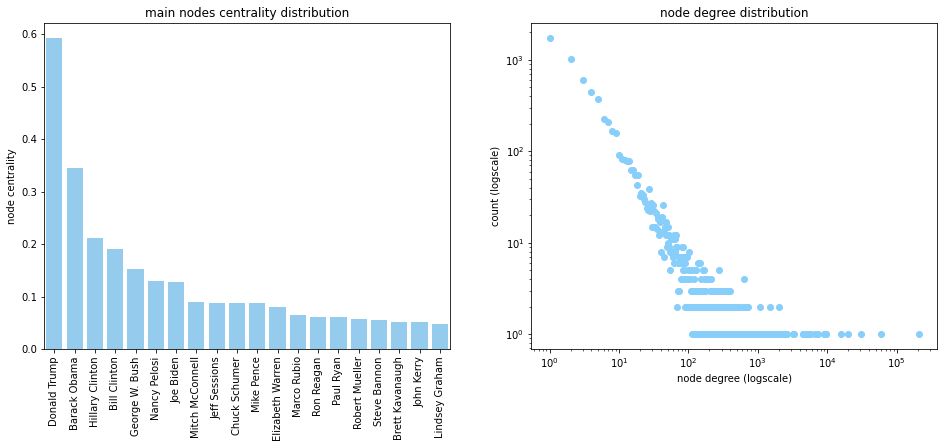

In [6]:
degrees = sorted(dict(g.degree(weight='weight')).values())
degree_counts = Counter(degrees)

centr=nx.degree_centrality(g)
sorted_centr=sorted(centr.items(), key=lambda x: x[1], reverse=True)[:20]
names=[catalogue_df.loc[catalogue_df.qid == qid, 'name'].item() for qid in [x[0] for x in sorted_centr]]

fig,axs=plt.subplots(1,2,figsize=(16,6))
axs[0].set_title('main nodes centrality distribution')
sns.barplot(names,[x[1] for x in sorted_centr], color='LightSkyBlue',ax=axs[0])
axs[0].tick_params('x',labelrotation = 90)
axs[0].set_ylabel('node centrality')

axs[1].set_title('node degree distribution')
axs[1].scatter([x for x in degree_counts], [degree_counts[x] for x in degree_counts], color='LightSkyBlue')
axs[1].set_xscale('log')
axs[1].set_xlabel('node degree (logscale)')
axs[1].set_yscale('log')
axs[1].set_ylabel('count (logscale)')
plt.show()

From the main nodes centrality distribution we can see obviously expected names (Donald Trump as main character of the network as well as Barack Obama etc) taking into account that the dataset spans from 2015 to 2020. It also seems to follow a power law distribution. The second graph, the node degree distribution, shows that the distribution follows a power law distribution, as expected for this type of big social network graph.

We then compute the Kernighan-Lin bisection of the graph and compute attributes of each community. Using this bisection, we compute two vectors with binary value of party and binary value of community respectively.

In [7]:
communities=community.kernighan_lin_bisection(g.to_undirected(),seed=42,weight='weight')
g0=g.subgraph(communities[0])
g1=g.subgraph(communities[1])

catalogue_graph=catalogue_df.loc[catalogue_df.qid.isin(list(g.nodes))].copy() #to keep only politicians in network
catalogue_graph.reset_index(drop=True, inplace=True)
binary_party = np.where(catalogue_graph.parties.loc[:] == 'Democratic Party',1,0)
binary_community = np.where(catalogue_graph.qid.isin(list(g0.nodes)),1,0)

We now compute Spearman correlation coefficient between the two new catalogue columns. Spearman correlation makes sense here because we want to capture if the 2 variables are correlated or anti-correlated, because we don't control which binary value will be given to which community (all same => Spearman coeff=1, all contrary => Spearman coeff=-1 and we take the absolute value). We don't want to just check similarity because it doesn't capture anti-correlation. [wikipedia link](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient). We use a  two-sided 95% confidence interval to verify statistical significance.

In [8]:
spearman_corr,spearman_pval=spearmanr(binary_party,binary_community)
abs_spearman_corr = np.abs(spearman_corr)
print(f'absolute value of Spearman correlation coefficient = {round(abs_spearman_corr,4)}, with a p-value of {round(spearman_pval,4)}')
if spearman_pval < .025:
    print(f'spearman correlation of coefficient p-value = {round(spearman_pval,4)} < 0.025, so there is a statististically significant correlation between the graph bisection and real politicians parties.')
else:
    print(f'spearman correlation of coefficient p-value = {round(spearman_pval,4)} > 0.025, so there is no statististically significant correlation between the two network communities and real politicians parties.')

absolute value of Spearman correlation coefficient = 0.0296, with a p-value of 0.0118
spearman correlation of coefficient p-value = 0.0118 < 0.025, so there is a statististically significant correlation between the graph bisection and real politicians parties.


We then see that there is a statiscally significant correlation between real Republican/Democratic politicians and the community bisection of our network, meaning US Republican/Democratic politicians have the tendency to more often mention their peers rather than opposite party politicians in the medias.

We built plotting functions to visualize the most important nodes and edges of our network to get a feeling of our network structure. Feel free to explore!

In [9]:
#this cell sets parameters used for vizualization
centr0=nx.degree_centrality(g0)
sorted_centr0_nodes=[x[0] for x in sorted(centr0.items(), key=lambda x: x[1], reverse=True)[:20]]
centr1=nx.degree_centrality(g1)
sorted_centr1_nodes=[x[0] for x in sorted(centr1.items(), key=lambda x: x[1], reverse=True)[:20]]

sorted_center_nodes=[]
sorted_center_nodes.extend(sorted_centr0_nodes)
sorted_center_nodes.extend(sorted_centr1_nodes)
g_centers=g.subgraph(sorted_center_nodes)
Laycentr=nx.kamada_kawai_layout(g_centers.to_undirected()) #for vizualisation
labels_centr=[catalogue_df.loc[catalogue_df.qid == qid, 'name'].item() for qid in g_centers.nodes()]
party_centr=[catalogue_df.loc[catalogue_df.qid == qid, 'parties'].item() for qid in g_centers.nodes()]
party_colmap=['tomato' if x=='Republican Party' else 'dodgerblue' for x in party_centr]

bisection_colmap=['darkgreen' if node in list(g0.nodes()) else 'gold' for node in g_centers.nodes]

centrality=scaler([centr[qid] for qid in g_centers.nodes()])
Lay_centr_bipart=nx.bipartite_layout(g_centers.to_undirected(),nodes=g0.nodes) #for vizualisation

In [10]:
plotly_graph(g_centers.to_undirected(),Laycentr,labels_centr,party_colmap,bisection_colmap,centrality,
            title='Most central nodes and edges of the network')

In this plot, only the 20 most central nodes of each community and main edges between them are shown. The fill color of each node represent its real party belongings and the surronding color represent the bisection community it belongs to. The size of the node represent the its centrality. To have an easier interpretable plot, we rendered the graph undirected so the edge weights add up. The width of the edges then represent the sum of the 2 edges between each node. Noticeably, The biggest nodes belongs to same community (Trump, Obama, Biden, ... etc). This is expected from the bisection algorithm since it looks to minimize the sum of weights between the two communities. It then benefit from clustering them together. But for statistical correlation we take into account the whole network and these nodes only represent a very small portion of it.

In [11]:
plotly_graph_bipartite(g_centers.to_undirected(),Lay_centr_bipart,labels_centr,party_colmap,bisection_colmap,centrality,
            title='Bipartition of the graph by community')

This plot shows the main nodes of each community in a bipartite layout corresponding to bisection community, as for before, fill color represent the party belonging, surronding color represent bisection community belongings and edges width represent edge weights.

We also decided that I would be interesting to vizualize self-mentionning frequency. For this, we use the same pipline to build a network but only keeping self loops.

In [ ]:
self_men_df=pd.DataFrame()
for i,row in df_full.iterrows():
    if row.qids in catalogue_df.qid.values:
        for mention_qid in row.mentions_qids:
            if row.qids == mention_qid:
                mention=pd.Series([row.qids,mention_qid,row.speaker])
                self_men_df=self_men_df.append(mention,ignore_index=True)
    #if i %10000==0: print(i)
self_men_df.rename(columns={0:'qid',1:'mentions_qid',2:'speaker'},inplace=True)

In [13]:
self_adj_df = pd.crosstab(self_men_df.qid, self_men_df.mentions_qids)
self_adj=self_adj_df.values

g_self=nx.from_numpy_matrix(self_adj)
g_self=nx.relabel_nodes(g_self,mapping=lambda x: self_adj_df.index[x])
print(f'self mentionning network characteristics: \n- number of nodes: {len(list(g_self.nodes))}')

self mentionning network characteristics: 
- number of nodes: 2493


To compute frequencies, we divide the number of self-mentionning occurencies for each node by the total number of mentionning other politician (out edges) from the previous network.

In [14]:
for node in g_self.nodes:
    total_edges=len(g.out_edges(node))
    if total_edges != 0:
        self_mentions=g_self.get_edge_data(node,node,'weight')['weight']
        fract=self_mentions/total_edges
    else: fract=0
    g_self[node][node]['weight']=fract

In [22]:
weights=list(g_self.edges(data='weight'))
sorted_self_weights=sorted(weights, key=lambda d:d[2], reverse=True)[:20]
g_self_centers=g_self.subgraph([x[0] for x in sorted_self_weights])
Lay_self_centr=nx.random_layout(g_self_centers,seed=10)
self_weights_centr=scaler([g_self_centers.get_edge_data(node,node,'weight')['weight']**2 for node in g_self_centers.nodes])
self_party_centr=[catalogue_df.loc[catalogue_df.qid == qid, 'parties'].item() for qid in g_self_centers.nodes()]
self_party_col_centr=['tomato' if x=='Republican Party' else 'dodgerblue' for x in self_party_centr]
self_labels=[catalogue_df.loc[catalogue_df.qid == qid, 'name'].item() for qid in g_self_centers.nodes()]
plotly_graph_self(g_self_centers,Lay_self_centr,self_labels,parties=self_party_col_centr,centrality=self_weights_centr,
            title='Self-mentionning frequencies')


In this plot, the 40 politicians with highest self-mentionning frequencies are shown. Color represents party belongings and size of nodes represent the number of frequency. Here are revealed the most selfish american politicians.